We are going to build a Finite State Transducer to derive Turkish Language plural word. The main problem in this application is determining which suffixes to use after a Turkish word. For example, after "kedi", we must put there "ler" suffix. After "Papağan", we must put there "lar" suffix. Let's begin.

Next function is for testing. I am going to give it a word, it is going to convert it to a list that consists of letters. At the end, it is going to put "+pl" suffix to point out we are going to make plural this word.

In [16]:
def string_to_list_with_suffix(input_string):
    char_list = list(input_string)
    char_list.append("+pl")
    return char_list

The next function is implemented to bring the input into a form suitable for the fst that I designed.
1. If the letter is front vowel, I indicate it as "e,i,ö,ü"
2. If the letter is back vowel, I indicate it as "a,ı,o,u"
3. If the letter is consonant, I indicate it as "cnsnt"

The need of this preprocessing step comes from complex visualization of FST. If I take all vowels separately, FST looks very big and complex. So, I grouped them. However, to use this group rules, I need a preprocessing step.

In [17]:
def process_string(input_string):
    result_list = []

    for char in input_string:
        if char in ['a', 'u', 'o', 'ı']:
            result_list.extend(['a,u,o,ı'])
        elif char in ['e', 'ü', 'ö', 'i']:
            result_list.extend(['e,ü,ö,i'])
        elif char.isalpha() and char.lower() not in ['a', 'e', 'ı', 'i', 'o', 'ö', 'u', 'ü']:
            result_list.append('sessiz')
    
    result_list.append('+pl')
    return result_list

The next function allows us to obtain the output we get as the fst states change. 
I got this function from Openfst-Python documentation: https://github.com/edemattos/asr/blob/master/asr_lab5_solutions.ipynb

I modified existing function a little bit. Let me explain what I change:
I am giving 2 parameter to function instead of 1. One of it is correct form of input for FST, other one is unchanged version of it. The algorithm is:
1. If input and output of a state is the same, give the input as output. Actually here we are solving this problem: If the output is "a,u,ı,o", we should pick the correct vowel of this string. And while picking the correct one, we should find it in the original input.
2. Else, give the original output of the current state.
3. I return the output as a list of string

In [18]:
def transduce_sequence_det(f, seq, seq2):
    """Return transduced sequence given input sequence and determinized FST
    
        Args:
            f (fst.Fst()): a determinized FST
            in_seq (list[str]): the sequence of strings to transduce
            
        Returns:
            out_seq (list[str]): the sequence of transduced symbols
            """
    
    seq_len = len(seq)
    eps = f.input_symbols().find('<eps>')
    curr_state = f.start()
    output = []
    
    for i in range(seq_len):
        found = False
        label = f.input_symbols().find(seq[i])
        for arc in f.arcs(curr_state):
            if arc.ilabel == label:
                if f.output_symbols().find(arc.olabel) == f.input_symbols().find(arc.ilabel):
                    output += seq2[i]
                else:
                    output += f.output_symbols().find(arc.olabel)
                    
                    
                curr_state = arc.nextstate
                found = True
                break  # no need to keep going through other arcs, as it's determinized
        if not found:
            print("Can't transduce the sequence with provided FST")
                
    final_weight = float(f.final(curr_state))
    if final_weight != math.inf: # if this is a final state
        #out_seq = [f.output_symbols().find(w) for w in output if w != eps]  # find the labels in the table, remove epsilons
        return output
    else:  
        print("Can't transduce the sequence with provided FST")

This is the main of this homework. Let's build the FST.
We have 4 input symbols:
1. cnsnt -> (Represents consonent letters)
2. "a,u,o,ı" -> (Represents front vowel letters)
3. "e,ü,ö,i" -> (Represents back vowel letters)
4. "+pl" -> (Represents plural suffix)

We have 5 output symbols:
1. cnsnt -> (Represents consonent letters)
2. "a,u,o,ı" -> (Represents front vowel letters)
3. "e,ü,ö,i" -> (Represents back vowel letters)
4. "lar" -> (Represents "lar" suffix)
5. "ler" -> (Represents "ler" suffix)

We have 4 states. The main thing in the machine is:
if we put plural suffix after a front vowel letter, the correct plural suffix must be "lar".
If we put plural suffix after a back vowel letter, the correct plural suffix must be "ler".

In Turkish, after a front vowel, the suitable plural suffix is "ler"
In Turkish, after a back vowel, the suitable plural suffix is "lar"


This FST images are also exist in the Report and the folder that I upload to Teams. You can check them.

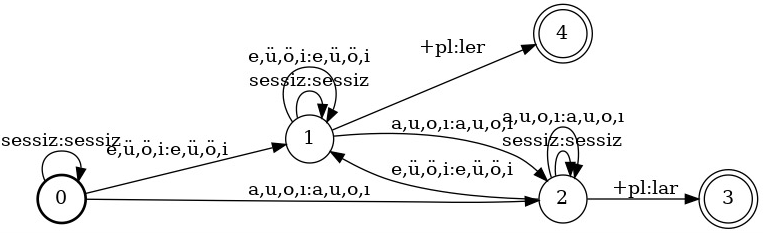

In [19]:
import openfst_python as fst
import math

def build_turkish_fst():
    turkish_fst = fst.Fst()

    input_sym = fst.SymbolTable()
    output_sym = fst.SymbolTable()
    
    input_sym.add_symbol('sessiz')
    output_sym.add_symbol('sessiz')
    
    input_sym.add_symbol('a,u,o,ı')
    output_sym.add_symbol('a,u,o,ı')
    
    input_sym.add_symbol('e,ü,ö,i')
    output_sym.add_symbol('e,ü,ö,i')
    
    input_sym.add_symbol('+pl')
    output_sym.add_symbol("lar")
    output_sym.add_symbol("ler")
   
    turkish_fst.set_input_symbols(input_sym)
    turkish_fst.set_output_symbols(output_sym)
    
    s0 = turkish_fst.add_state()
    s1 = turkish_fst.add_state()
    s2 = turkish_fst.add_state()
    s3 = turkish_fst.add_state()
    s4 = turkish_fst.add_state()
   
    consonent_input = input_sym.find('sessiz')
    consonent_output = output_sym.find('sessiz')
    
    back_vowels_input = input_sym.find('a,u,o,ı')
    back_vowels_output = output_sym.find('a,u,o,ı')
    
    front_vowels_input = input_sym.find('e,ü,ö,i')
    front_vowels_output = output_sym.find('e,ü,ö,i')
    
    plus_pl = input_sym.find('+pl')
    
    lar_suffix = output_sym.find('lar')
    ler_suffix = output_sym.find('ler')
    

    turkish_fst.add_arc(s0, fst.Arc(consonent_input, consonent_output, None, s0))
    turkish_fst.add_arc(s0, fst.Arc(front_vowels_input, front_vowels_output, None, s1))
    turkish_fst.add_arc(s0, fst.Arc(back_vowels_input, back_vowels_output, None, s2))
    
    turkish_fst.add_arc(s1, fst.Arc(consonent_input, consonent_output, None, s1))
    turkish_fst.add_arc(s2, fst.Arc(consonent_input, consonent_output, None, s2))
    
    turkish_fst.add_arc(s1, fst.Arc(back_vowels_input, back_vowels_output, None, s2))
    turkish_fst.add_arc(s2, fst.Arc(front_vowels_input, front_vowels_output, None, s1))
    
    turkish_fst.add_arc(s2, fst.Arc(back_vowels_input, back_vowels_output, None, s2))
    turkish_fst.add_arc(s1, fst.Arc(front_vowels_input, front_vowels_output, None, s1))

    
    turkish_fst.add_arc(s2, fst.Arc(plus_pl, lar_suffix, None, s3))
    turkish_fst.add_arc(s1, fst.Arc(plus_pl, ler_suffix, None, s4))
    
    turkish_fst.set_start(s0)
    turkish_fst.set_final(s3)
    turkish_fst.set_final(s4)

    return turkish_fst

Let's test the all plural FST machine and algorithms with 10 words

In [20]:
from graphviz import render
from IPython.display import Image, display

def get_result_for_plural(test_word, turkish_fst):
    string2 = process_string(test_word)
    string = string_to_list_with_suffix(test_word)
    res = transduce_sequence_det(turkish_fst, string2, string)
    result_string = ''.join(res)
    return result_string

def main_for_plural():
    turkish_fst = build_turkish_fst()

    turkish_fst.draw("turkish_fst.dot")
    print("FST diagram saved as turkish_fst.dot")

    #png_file_gen = "turkish_fst.png"
    #render('dot', 'png', "turkish_fst.dot", png_file_gen)

    print('''\n\nPlural -ler suffix examples:''')
    print("kalem + pl -> ", get_result_for_plural("kalem", turkish_fst))
    print("pencere + pl -> ", get_result_for_plural("pencere", turkish_fst))
    print("şemsiye + pl -> ", get_result_for_plural("şemsiye", turkish_fst))
    print("silgi + pl -> ", get_result_for_plural("silgi", turkish_fst))
    print("küllük + pl -> ", get_result_for_plural("küllük", turkish_fst))
    print("simit + pl -> ", get_result_for_plural("simit", turkish_fst))
    print("necip + pl -> ", get_result_for_plural("necip", turkish_fst))
    print("asker + pl -> ", get_result_for_plural("asker", turkish_fst))
    print("şehit + pl -> ", get_result_for_plural("şehit", turkish_fst))
    print("terbiyesiz + pl -> ", get_result_for_plural("terbiyesiz", turkish_fst))
    print("örgüt + pl -> ", get_result_for_plural("örgüt", turkish_fst))
    
    print('''\n\nPlural -lar suffix examples:''')
    print("kağıt + pl -> ", get_result_for_plural("kağıt", turkish_fst))
    print("kapı + pl -> ", get_result_for_plural("kapı", turkish_fst))
    print("top + pl -> ", get_result_for_plural("top", turkish_fst))
    print("kırmızı + pl -> ", get_result_for_plural("kırmızı", turkish_fst))
    print("saç + pl -> ", get_result_for_plural("saç", turkish_fst))
    print("kahraman + pl -> ", get_result_for_plural("kahraman", turkish_fst))
    print("telefon + pl -> ", get_result_for_plural("telefon", turkish_fst))
    print("tavuk + pl -> ", get_result_for_plural("tavuk", turkish_fst))
    print("karpuz + pl -> ", get_result_for_plural("karpuz", turkish_fst))
    print("beşiktaşlı + pl -> ", get_result_for_plural("beşiktaşlı",turkish_fst))

 2 - Possessive Form of Words

I create 2 FST for this problem. First one is to handle softening (yumuşama) problem in Turkish. It is going to solve softening and produce new input to give the second FST. This FST is an intermediate step for possessive FST. Its output is input for possessive FST.

Let's start with first FST to solve softening problem. 

The function below is implemented for removing epsilon characters from the result since some states in the FST produces epsilon (none) characters.

In [21]:
def process_output(output):
    # Remove epsilon characters (represented by an empty string) from the output list
    output_without_epsilon = [char for char in output if char != 'ε']
    return output_without_epsilon

When we are getting input. There is a small preprocessing step. To bring the input into a form suitable for the fst that I designed, I implemented a function:

If a character in the input is not any of these {"+1pp" , "+2pp" , "+3pp" ,"+1sp", "+2sp", "+3sp", "p", "ç", "t", "k"}, I labelled it as “other”
The need of this preprocessing step comes from complex visualization of FST. If I take all vowels separately, FST looks very big and complex. So, I grouped them. However, to use this group rules, I need this preprocessing step.


In [22]:
def replace_strings_with_other(input_list):
    allowed_strings = {"+1pp" , "+2pp" , "+3pp" ,"+1sp", "+2sp", "+3sp", "p", "ç", "t", "k"}
    result_list = ["other" if item not in allowed_strings else item for item in input_list]
    return result_list

The next function allows us to obtain the output we get as the fst states change. It is very similar to plural FST version.
I got this function from Openfst-Python documentation: https://github.com/edemattos/asr/blob/master/asr_lab5_solutions.ipynb

I modified existing function a little bit. Let me explain what I change:
I am giving 2 parameter to function instead of 1. One of it is correct form of input for FST, other one is unchanged version of it. The algorithm is:
1. If the input is "other", we should check the current state. If the current state is 1 or 2 or 3 or 4, it means that there is NO a softening operation. So, we should produce original form of previous read character before the possessive indicator. The "other" input in the state of 1,2,3 and 4 means that any other input except possessive suffix. So, I put an additional condition to detect if a voiceless consonent comes after a voiceless consonant. It must be considered as "other"
3. If the input is "other" and the current state is not 1 or 2 or 3 or 4, we should produce what we read.  
4. If the input is not "other", again we should check the current state. If it is not 0 and 9,  it means that there is a softening operation. So, we should produce softened form of previous read character before the possessive indicator.
5. If the input is not "other", and the state is 0 or 9, we should produce output of the state as what it is.

In [23]:
def transduce_sequence_det1(f, seq, seq2):
    """Return transduced sequence given input sequence and determinized FST
    
        Args:
            f (fst.Fst()): a determinized FST
            in_seq (list[str]): the sequence of strings to transduce
            
        Returns:
            out_seq (list[str]): the sequence of transduced symbols
            """
    
    seq_len = len(seq)
    eps = f.input_symbols().find('ε')
    curr_state = f.start()
    output = []
    
    for i in range(seq_len):
        found = False
        label = f.input_symbols().find(seq[i])
        for arc in f.arcs(curr_state):
            voiceless_after_voiceless = (curr_state == 1 or curr_state == 2 or curr_state == 3 or curr_state == 4) and \
                            (seq[i] == 'p' or 
                             seq[i] == 'ç' or
                             seq[i] == 't' or
                             seq[i] == 'k')
            
            if arc.ilabel == label or voiceless_after_voiceless:
                if(f.input_symbols().find(arc.ilabel)=='other' or voiceless_after_voiceless):
                    if(curr_state == 1 or curr_state==2 or curr_state==3 or curr_state==4):
                        result_list = f.output_symbols().find(arc.olabel).split(',')
                        output.append(result_list[0])
                        output.append(seq2[i])
                    
                    else:
                        output.append(seq2[i])
                        
                    found = True
                    curr_state = arc.nextstate
                else:
                    if(curr_state!=0 and curr_state!=9):
                        output.append(f.output_symbols().find(arc.olabel)[0])
                        output.append(f.output_symbols().find(arc.olabel)[1:])
                    else:
                        output.append(f.output_symbols().find(arc.olabel))
                    curr_state = arc.nextstate
                    found = True
                    break  # no need to keep going through other arcs, as it's determinized
        if not found:
            print("Can't transduce the sequence with provided FST")
                
    final_weight = float(f.final(curr_state))
    if final_weight != math.inf: # if this is a final state
        return process_output(output)
    else:  
        print("Can't transduce the sequence with provided FST")

Now, this is the generation of FST that applies softening operation.
Input symbols:
1. "sesli"
2. "p"
3. "ç"
4. "t"
5. "k"
6. "+1sp"
7. "+2sp"
8. "+3sp"
9. "+1pp"
10. "+2pp"
11. "+3pp"
12. "other"

Output symbols:
1. "sesli"
2. "b+3pp" -> This is a multiple output. softened letter and possessive suffix.
3. "b+2pp"
4. "b+1pp"
5. "b+3sp"
6. "b+2sp"
7. "b+1sp"
8. "c+3pp"
9. "c+2pp"
10. "c+1pp"
11. "c+3sp"
12. "c+2sp"
13. "c+1sp"
14. "d+3pp"
15. "d+2pp"
16. "d+1pp"
17. "d+3sp"
18. "d+2sp"
19. "d+1sp"
20. "ğ+3pp"
21. "ğ+2pp"
22. "ğ+1pp"
23. "ğ+3sp"
24. "ğ+2sp"
25. "ğ+1sp"
26. "p,other" -> This is multiple output. It produces "p" letter and "other". Here, the "other" represents what we read.
27. "ç,other"
28. "t,other"
29. "k,other"
30. "epsilon" -> This is empty output.
31. "other" -> Represents what we read.

Algorithm is here:
If the word ends with "p" or "ç" or "t" or "k", it means that there is a softening operation and we need to change these letters as "b" or "c" or "d" or "ğ" letters. FST adds the posessive suffix of input to the end of result string. It is going to be given to other level as input

Visualized FST:

This FST images are also exist in the Report and the folder that I upload to Teams. You can check them.
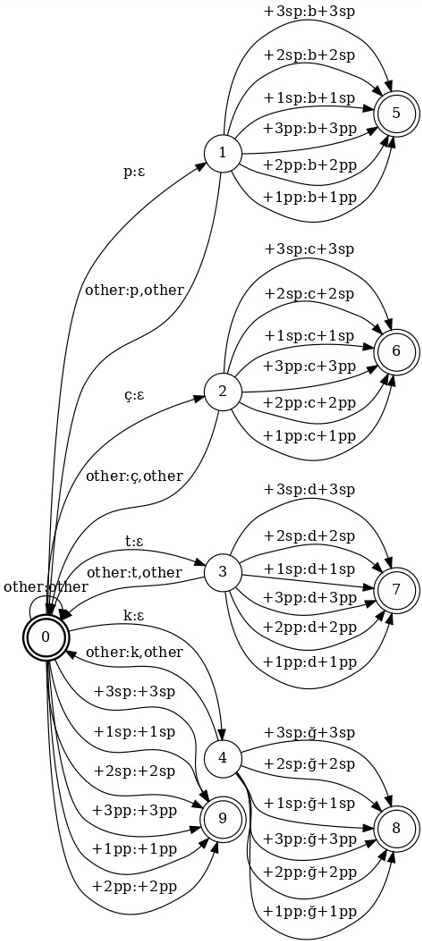

In [24]:

import openfst_python as fst
import math
input_sym = fst.SymbolTable()
output_sym = fst.SymbolTable()

# Function to find symbols and create variables
def get_symbol_variable(sym_table, symbol_name):
    return sym_table.find(symbol_name)

def build_turkish_fst_posessive_singular():
    # Create an FST
    turkish_fst = fst.Fst()

    input_sym = fst.SymbolTable()
    output_sym = fst.SymbolTable()
    
    input_sym.add_symbol('other')
    output_sym.add_symbol('other')
    
    input_sym.add_symbol('sesli')
    output_sym.add_symbol('sesli')
    
    input_sym.add_symbol('p')
    output_sym.add_symbol('p')
    output_sym.add_symbol('ε')
    
    input_sym.add_symbol('ç')
    output_sym.add_symbol('ç')
    output_sym.add_symbol('ε')
    
    input_sym.add_symbol('t')
    output_sym.add_symbol('t')
    output_sym.add_symbol('ε')
    
    input_sym.add_symbol('k')
    output_sym.add_symbol('k')
    output_sym.add_symbol('ε')
    
    
    
    input_sym.add_symbol('+3sp')
    output_sym.add_symbol('+3sp')
    output_sym.add_symbol('b+3sp')
    output_sym.add_symbol('c+3sp')
    output_sym.add_symbol('d+3sp')
    output_sym.add_symbol('ğ+3sp')
    
    input_sym.add_symbol('+2sp')
    output_sym.add_symbol('+2sp')
    output_sym.add_symbol('b+2sp')
    output_sym.add_symbol('c+2sp')
    output_sym.add_symbol('d+2sp')
    output_sym.add_symbol('ğ+2sp')
    
    input_sym.add_symbol('+1sp')
    output_sym.add_symbol('+1sp')
    output_sym.add_symbol('b+1sp')
    output_sym.add_symbol('c+1sp')
    output_sym.add_symbol('d+1sp')
    output_sym.add_symbol('ğ+1sp')
    
    #new
    input_sym.add_symbol('+3pp')
    output_sym.add_symbol('+3pp')
    output_sym.add_symbol('b+3pp')
    output_sym.add_symbol('c+3pp')
    output_sym.add_symbol('d+3pp')
    output_sym.add_symbol('ğ+3pp')
    
    input_sym.add_symbol('+2pp')
    output_sym.add_symbol('+2pp')
    output_sym.add_symbol('b+2pp')
    output_sym.add_symbol('c+2pp')
    output_sym.add_symbol('d+2pp')
    output_sym.add_symbol('ğ+2pp')
    
    input_sym.add_symbol('+1pp')
    output_sym.add_symbol('+1pp')
    output_sym.add_symbol('b+1pp')
    output_sym.add_symbol('c+1pp')
    output_sym.add_symbol('d+1pp')
    output_sym.add_symbol('ğ+1pp')
    #new
    
    output_sym.add_symbol('p,other')
    output_sym.add_symbol('ç,other')
    output_sym.add_symbol('t,other')
    output_sym.add_symbol('k,other')

    turkish_fst.set_input_symbols(input_sym)
    turkish_fst.set_output_symbols(output_sym)
    
    s0 = turkish_fst.add_state()
    s1 = turkish_fst.add_state()
    s2 = turkish_fst.add_state()
    s3 = turkish_fst.add_state()
    s4 = turkish_fst.add_state()
    s5 = turkish_fst.add_state()
    s6 = turkish_fst.add_state()
    s7 = turkish_fst.add_state()
    s8 = turkish_fst.add_state()
    s9 = turkish_fst.add_state()

    other_input = input_sym.find('other')
    other_output = output_sym.find('other')
    
    p_input = input_sym.find('p')
    c_input = input_sym.find('ç')
    t_input = input_sym.find('t')
    k_input = input_sym.find('k')
    
    p_output_with_other = output_sym.find('p,other')
    c_output_with_other = output_sym.find('ç,other')
    t_output_with_other = output_sym.find('t,other')
    k_output_with_other = output_sym.find('k,other')
    
    input_1sp = input_sym.find('+1sp')
    output_1sp = output_sym.find('+1sp')
    soft_output_p_1sp = output_sym.find('b+1sp')
    soft_output_c_1sp = output_sym.find('c+1sp')
    soft_output_t_1sp = output_sym.find('d+1sp')
    soft_output_k_1sp = output_sym.find('ğ+1sp')
    
    input_2sp = input_sym.find('+2sp')
    output_2sp = output_sym.find('+2sp')
    soft_output_p_2sp = output_sym.find('b+2sp')
    soft_output_c_2sp = output_sym.find('c+2sp')
    soft_output_t_2sp = output_sym.find('d+2sp')
    soft_output_k_2sp = output_sym.find('ğ+2sp')
    
    input_3sp = input_sym.find('+3sp')
    output_3sp = output_sym.find('+3sp')
    soft_output_p_3sp = output_sym.find('b+3sp')
    soft_output_c_3sp = output_sym.find('c+3sp')
    soft_output_t_3sp = output_sym.find('d+3sp')
    soft_output_k_3sp = output_sym.find('ğ+3sp')
    
    #new
    input_1pp = input_sym.find('+1pp')
    output_1pp = output_sym.find('+1pp')
    soft_output_p_1pp = output_sym.find('b+1pp')
    soft_output_c_1pp = output_sym.find('c+1pp')
    soft_output_t_1pp = output_sym.find('d+1pp')
    soft_output_k_1pp = output_sym.find('ğ+1pp')
    
    input_2pp = input_sym.find('+2pp')
    output_2pp = output_sym.find('+2pp')
    soft_output_p_2pp = output_sym.find('b+2pp')
    soft_output_c_2pp = output_sym.find('c+2pp')
    soft_output_t_2pp = output_sym.find('d+2pp')
    soft_output_k_2pp = output_sym.find('ğ+2pp')
    
    input_3pp = input_sym.find('+3pp')
    output_3pp = output_sym.find('+3pp')
    soft_output_p_3pp = output_sym.find('b+3pp')
    soft_output_c_3pp = output_sym.find('c+3pp')
    soft_output_t_3pp = output_sym.find('d+3pp')
    soft_output_k_3pp = output_sym.find('ğ+3pp')
    #new
    
    epsilon_output = output_sym.find('ε')
    
    
    turkish_fst.add_arc(s0, fst.Arc(other_input, other_output, None, s0))
    turkish_fst.add_arc(s0, fst.Arc(p_input, epsilon_output, None, s1))
    turkish_fst.add_arc(s0, fst.Arc(c_input, epsilon_output, None, s2))
    turkish_fst.add_arc(s0, fst.Arc(t_input, epsilon_output, None, s3))
    turkish_fst.add_arc(s0, fst.Arc(k_input, epsilon_output, None, s4))
    
    turkish_fst.add_arc(s0, fst.Arc(input_3sp, output_3sp, None, s9))
    turkish_fst.add_arc(s0, fst.Arc(input_1sp, output_1sp, None, s9))
    turkish_fst.add_arc(s0, fst.Arc(input_2sp, output_2sp, None, s9))
    turkish_fst.add_arc(s0, fst.Arc(input_3pp, output_3pp, None, s9))
    turkish_fst.add_arc(s0, fst.Arc(input_1pp, output_1pp, None, s9))
    turkish_fst.add_arc(s0, fst.Arc(input_2pp, output_2pp, None, s9))
    
    turkish_fst.add_arc(s1, fst.Arc(other_input, p_output_with_other, None, s0))
    turkish_fst.add_arc(s2, fst.Arc(other_input, c_output_with_other, None, s0))
    turkish_fst.add_arc(s3, fst.Arc(other_input, t_output_with_other, None, s0))
    turkish_fst.add_arc(s4, fst.Arc(other_input, k_output_with_other, None, s0))
    
    turkish_fst.add_arc(s1, fst.Arc(input_3sp, soft_output_p_3sp, None, s5))
    turkish_fst.add_arc(s1, fst.Arc(input_2sp, soft_output_p_2sp, None, s5))
    turkish_fst.add_arc(s1, fst.Arc(input_1sp, soft_output_p_1sp, None, s5))
    #new
    turkish_fst.add_arc(s1, fst.Arc(input_3pp, soft_output_p_3pp, None, s5))
    turkish_fst.add_arc(s1, fst.Arc(input_2pp, soft_output_p_2pp, None, s5))
    turkish_fst.add_arc(s1, fst.Arc(input_1pp, soft_output_p_1pp, None, s5))
    #new
    
    turkish_fst.add_arc(s2, fst.Arc(input_3sp, soft_output_c_3sp, None, s6))
    turkish_fst.add_arc(s2, fst.Arc(input_2sp, soft_output_c_2sp, None, s6))
    turkish_fst.add_arc(s2, fst.Arc(input_1sp, soft_output_c_1sp, None, s6))
    #new
    turkish_fst.add_arc(s2, fst.Arc(input_3pp, soft_output_c_3pp, None, s6))
    turkish_fst.add_arc(s2, fst.Arc(input_2pp, soft_output_c_2pp, None, s6))
    turkish_fst.add_arc(s2, fst.Arc(input_1pp, soft_output_c_1pp, None, s6))
    #new
    
    turkish_fst.add_arc(s3, fst.Arc(input_3sp, soft_output_t_3sp, None, s7))
    turkish_fst.add_arc(s3, fst.Arc(input_2sp, soft_output_t_2sp, None, s7))
    turkish_fst.add_arc(s3, fst.Arc(input_1sp, soft_output_t_1sp, None, s7))
    #new
    turkish_fst.add_arc(s3, fst.Arc(input_3pp, soft_output_t_3pp, None, s7))
    turkish_fst.add_arc(s3, fst.Arc(input_2pp, soft_output_t_2pp, None, s7))
    turkish_fst.add_arc(s3, fst.Arc(input_1pp, soft_output_t_1pp, None, s7))
    #new
    
    turkish_fst.add_arc(s4, fst.Arc(input_3sp, soft_output_k_3sp, None, s8))
    turkish_fst.add_arc(s4, fst.Arc(input_2sp, soft_output_k_2sp, None, s8))
    turkish_fst.add_arc(s4, fst.Arc(input_1sp, soft_output_k_1sp, None, s8))
    #new
    turkish_fst.add_arc(s4, fst.Arc(input_3pp, soft_output_k_3pp, None, s8))
    turkish_fst.add_arc(s4, fst.Arc(input_2pp, soft_output_k_2pp, None, s8))
    turkish_fst.add_arc(s4, fst.Arc(input_1pp, soft_output_k_1pp, None, s8))
    #new
    
    
    turkish_fst.set_start(s0)
    turkish_fst.set_final(s0)
    turkish_fst.set_final(s5)
    turkish_fst.set_final(s6)
    turkish_fst.set_final(s7)
    turkish_fst.set_final(s8)
    turkish_fst.set_final(s9)

    return turkish_fst


The next function allows us to obtain the output we get as the fst states change. It is very similar to plural FST version.
I got this function from Openfst-Python documentation: https://github.com/edemattos/asr/blob/master/asr_lab5_solutions.ipynb

I modified existing function a little bit. Let me explain what I change:
This time, I did NOT change the parameter number of this functon. I process the input at the beginning of the loop to convert the input correct form for my FST:
I change the input to "a,ı" if the input is "a" or "ı"
I change the input to "o,u" if the input is "o" or "u"
I change the input to "e,i" if the input is "e" or "i"
I change the input to "ö,ü" if the input is "ö" or "ü"

After that, we produce correct outputs. If the input is "a,ı" or "o,u" or "e,i" or "ö,ü" or "cnsnt" (sessiz harf) it means that we should produce exact character of input according to FST. Else, we should produce exactly the same as the FST output.

In [25]:
import openfst_python as fst
import math

def list_to_string(input_list):
    return ''.join(input_list)

def transduce_sequence_det2(f, seq):
    """Return transduced sequence given input sequence and determinized FST
    
        Args:
            f (fst.Fst()): a determinized FST
            in_seq (list[str]): the sequence of strings to transduce
            
        Returns:
            out_seq (list[str]): the sequence of transduced symbols
            """
    
    seq_len = len(seq)
    eps = f.input_symbols().find('ε')
    curr_state = f.start()
    output = []
    turkish_consonants = ['b', 'c', 'ç', 'd', 'f', 'g', 'ğ', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'r', 's', 'ş', 't', 'v', 'y', 'z']

    
    for i in range(seq_len):
        found = False
        if all(char in turkish_consonants for char in seq[i]):
            label = f.input_symbols().find('cnsnt')
        elif(seq[i]=='a' or seq[i]=='ı'):
            label = f.input_symbols().find('a,ı')
        elif(seq[i]=='u' or seq[i]=='o'):
            label = f.input_symbols().find('u,o')
        elif(seq[i]=='e' or seq[i]=='i'):
            label = f.input_symbols().find('e,i')
        elif(seq[i]=='ü' or seq[i]=='ö'):
            label = f.input_symbols().find('ü,ö')
        else:
            label = f.input_symbols().find(seq[i])
        for arc in f.arcs(curr_state):
            if arc.ilabel == label:
                if((f.input_symbols().find(arc.ilabel)=='a,ı')
                        or (f.input_symbols().find(arc.ilabel)=='e,i')
                        or (f.input_symbols().find(arc.ilabel)=='ü,ö')
                        or (f.input_symbols().find(arc.ilabel)=='u,o')
                        or (f.input_symbols().find(arc.ilabel)=='cnsnt')):
                                              
                    output.append(seq[i])
                    found = True
                    curr_state = arc.nextstate
                    break
                         
                else:
                    output.append(f.output_symbols().find(arc.olabel))
                    curr_state = arc.nextstate
                    found = True
                    break  # no need to keep going through other arcs, as it's determinized
                    
        if not found:
            print("Can't transduce the sequence with provided FST")
                
    final_weight = float(f.final(curr_state))
    if final_weight != math.inf: # if this is a final state
        return process_output(output)
    else:  
        print("Can't transduce the sequence with provided FST")

Now, we are going to build the most complicated FST in this homework. It seems complicated by looking at the image but actually it is not. I am going to clarify the FST.

Input Symbols:
1. "cnsnt" -> Consonant letters of Turkish
2. "a,ı" -> "a" and "ı" letters
3. "u,o"
4. "e,i"
5. "ü,ö"
6. "+3sp" -> Third person singular possessive suffix
7. "+2sp" -> Second person singular possessive suffix
8. "+1sp" -> First person singular possessive suffix
9. "+3pp" -> Third person plural possessive suffix
10. "+2pp" -> Second person plural possessive suffix
11. "+1pp" -> First person plural possessive suffix

Output Symbols:
1. "cnsnt"
2. "a,ı" -> "a" and "ı" letters
3. "u,o"
4. "e,i"
5. "ü,ö"

6. "sı" -> 3sp and 3pp possessive suffix
7. "si" -> 3sp and 3pp possessive suffix
8. "ı" -> 3sp and 3pp possessive suffix
9. "i" -> 3sp and 3pp possessive suffix
10. "su" -> 3sp and 3pp possessive suffix
11. "sü" -> 3sp and 3pp possessive suffix
12. "u" -> 3sp and 3pp possessive suffix
13. "ü" -> 3sp and 3pp possessive suffix

14. "in" -> 2sp possessive suffix
15. "ın" -> 2sp possessive suffix
16. "ün" -> 2sp possessive suffix
17. "un" -> 2sp possessive suffix
18. "n" -> 2sp possessive suffix

19. "iniz" -> 2pp possessive suffix
20. "ınız" -> 2pp possessive suffix
21. "niz" -> 2pp possessive suffix
22. "nız" -> 2pp possessive suffix
23. "nuz" -> 2pp possessive suffix
24. "nüz" -> 2pp possessive suffix
25. "unuz" -> 2pp possessive suffix
26. "ünüz" -> 2pp possessive suffix

27. "im" -> 1sp possessive suffix
28. "um" -> 1sp possessive suffix
29. "üm" -> 1sp possessive suffix
30. "ım" -> 1sp possessive suffix
31. "m" -> 1sp possessive suffix

32. "imiz" -> 1pp possessive suffix
33. "ımız" -> 1pp possessive suffix
34. "miz" -> 1pp possessive suffix
35. "mız" -> 1pp possessive suffix
36. "ümüz" -> 1pp possessive suffix
37. "umuz" -> 1pp possessive suffix
38. "muz" -> 1pp possessive suffix
39. "müz" -> 1pp possessive suffix

Let me tell the algorithm:

Firstly, if the word ends with a consonant letter, we must add an additional letter there. For example, possessive form of asa "asa + m" but possessive form of "kalem" is "kalem + im". So, we need to check which letter we read before the possessive suffix. If we are in the state of consonent letter, we are going to add this additional character. That is why we have some states after each vowel letter state.

Secondly, we need to indicate which possessive suffix will be used after a vowel letter:
1. If the possessive suffix comes after "a" or "ı", we are gonna put there "mız" "ınız" "ı" as examples. As you see suffixes are formed with "ı" letter. Example: "can'ım"
2. If the possessive suffix comes after "e" or "i", we are gonna put there "miz" "iniz" "i" as examples. As you see suffixes are formed with "i" letter. Example: "güzel'im"
3. If the possessive suffix comes after "o" or "u", we are gonna put there "muz" "unuz" "u" as examples. As you see suffixes are formed with "u" letter. Example: "kuzu'm"
4. If the possessive suffix comes after "ö" or "ü", we are gonna put there "müz" "ünüz" "ü" as examples. As you see suffixes are formed with "ü" letter. Example: "bücür'üm"

So, at the end we need 4 states for vowel cases. And for each vowel case, we need a consonant case. At the end, we will have 8 states excluding final and start states. As I said, this consonant states for deciding we are going to add an additional character or not to the possessive suffix. The main thing we did is to decide which type of letter we read: "consonent", "a,ı", "e,i", "u,o", "ü,ö" or possessive suffix inputs. We just change the states according to this information. In summary, there are too many edges between states but as I said, in fact it is very simple.

This FST images are also exist in the Report and the folder that I upload to Teams. You can check them.


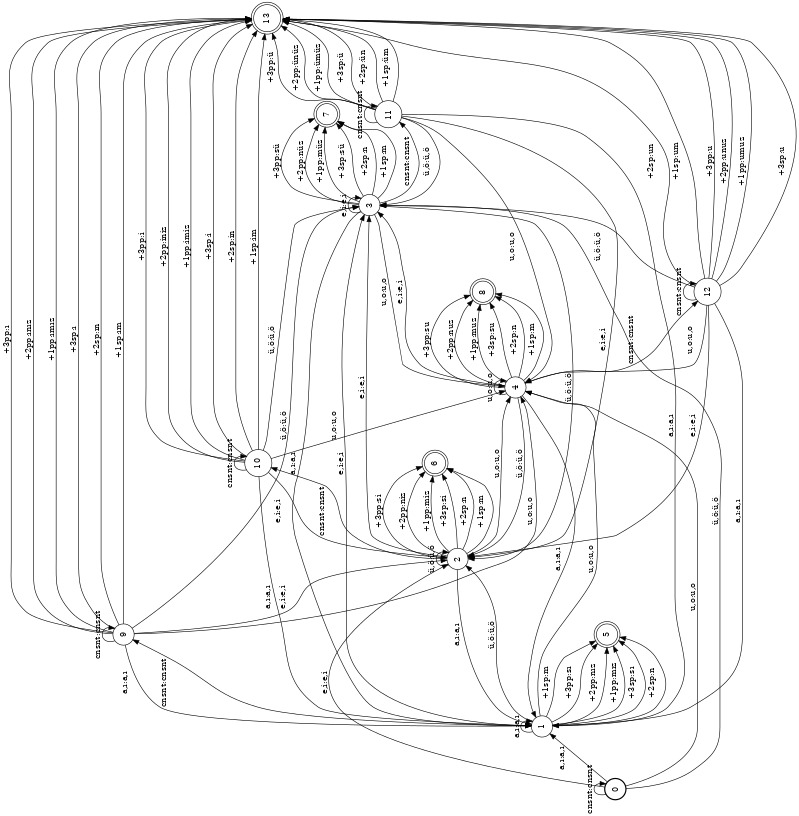

In [26]:
import openfst_python as fst
import math

def build_turkish_fst_posessive_general():
    # Create an FST
    turkish_fst = fst.Fst()

    input_sym = fst.SymbolTable()
    output_sym = fst.SymbolTable()
    
    input_sym.add_symbol('cnsnt')
    output_sym.add_symbol('cnsnt')
    
    input_sym.add_symbol('a,ı')
    output_sym.add_symbol('a,ı')
                         
    input_sym.add_symbol('u,o')
    output_sym.add_symbol('u,o')
    
    input_sym.add_symbol('e,i')
    output_sym.add_symbol('e,i')
                         
    input_sym.add_symbol('ü,ö')
    output_sym.add_symbol('ü,ö')
                          
    input_sym.add_symbol('+3sp')
    output_sym.add_symbol('+3sp')
    output_sym.add_symbol('sı')
    output_sym.add_symbol('si')
    output_sym.add_symbol('ı')
    output_sym.add_symbol('i')
    output_sym.add_symbol('su')
    output_sym.add_symbol('sü')
    output_sym.add_symbol('u')
    output_sym.add_symbol('ü')  
    
    input_sym.add_symbol('+3pp')
    output_sym.add_symbol('+3pp')
    
    input_sym.add_symbol('+2sp')
    output_sym.add_symbol('in')
    output_sym.add_symbol('ın')
    output_sym.add_symbol('ün')
    output_sym.add_symbol('un')
    output_sym.add_symbol('n')
    
    input_sym.add_symbol('+2pp')
    output_sym.add_symbol('iniz')
    output_sym.add_symbol('ınız')
    output_sym.add_symbol('niz')
    output_sym.add_symbol('nız')
    output_sym.add_symbol('nuz')
    output_sym.add_symbol('nüz')
    output_sym.add_symbol('unuz')
    output_sym.add_symbol('ünüz')
    
    input_sym.add_symbol('+1sp')
    output_sym.add_symbol('im')
    output_sym.add_symbol('um')
    output_sym.add_symbol('üm')
    output_sym.add_symbol('ım')
    output_sym.add_symbol('m')

    
    input_sym.add_symbol('+1pp')
    output_sym.add_symbol('imiz')
    output_sym.add_symbol('ımız')
    output_sym.add_symbol('miz')
    output_sym.add_symbol('mız')
    output_sym.add_symbol('ümüz')
    output_sym.add_symbol('umuz')
    output_sym.add_symbol('muz')
    output_sym.add_symbol('müz')
      

    turkish_fst.set_input_symbols(input_sym)
    turkish_fst.set_output_symbols(output_sym)
    
    s0 = turkish_fst.add_state()
    s1 = turkish_fst.add_state()
    s2 = turkish_fst.add_state()
    s3 = turkish_fst.add_state()
    s4 = turkish_fst.add_state()
    s5 = turkish_fst.add_state()
    s6 = turkish_fst.add_state()
    s7 = turkish_fst.add_state()
    s8 = turkish_fst.add_state()
    s9 = turkish_fst.add_state()
    s10 = turkish_fst.add_state()
    s11 = turkish_fst.add_state()
    s12 = turkish_fst.add_state()
    s13 = turkish_fst.add_state()

   
    cnsnt_output = get_symbol_variable(output_sym, 'cnsnt')
    cnsnt_input = get_symbol_variable(input_sym, 'cnsnt')


    aii_input = get_symbol_variable(input_sym, 'a,ı')
    aii_output = get_symbol_variable(output_sym, 'a,ı')
                          
    uo_input = get_symbol_variable(input_sym, 'u,o')
    uo_output = get_symbol_variable(output_sym, 'u,o')

    ei_input = get_symbol_variable(input_sym, 'e,i')
    ei_output = get_symbol_variable(output_sym, 'e,i')

    uuoo_input = get_symbol_variable(input_sym, 'ü,ö')                          
    uuoo_output = get_symbol_variable(output_sym, 'ü,ö')

    plus3sp_input = get_symbol_variable(input_sym, '+3sp')
    plus3sp_output = get_symbol_variable(output_sym, '+3sp')
    sii_output = get_symbol_variable(output_sym, 'sı')
    si_output = get_symbol_variable(output_sym, 'si')
    ii_output = get_symbol_variable(output_sym, 'ı')
    i_output = get_symbol_variable(output_sym, 'i')
    su_output = get_symbol_variable(output_sym, 'su')
    suu_output = get_symbol_variable(output_sym, 'sü')
    u_output = get_symbol_variable(output_sym, 'u')
    uu_output = get_symbol_variable(output_sym, 'ü')

    plus3pp_input = get_symbol_variable(input_sym, '+3pp')
    plus3pp_output = get_symbol_variable(output_sym, '+3pp')

    plus2sp_input = get_symbol_variable(input_sym, '+2sp')
    in_output = get_symbol_variable(output_sym, 'in')
    iin_output = get_symbol_variable(output_sym, 'ın')
    n_output = get_symbol_variable(output_sym, 'n')
    un_output = get_symbol_variable(output_sym, 'un')
    uun_output = get_symbol_variable(output_sym, 'ün')
                          
    plus2pp_input = get_symbol_variable(input_sym, '+2pp')
    iniz_output = get_symbol_variable(output_sym, 'iniz')
    iiniiz_output = get_symbol_variable(output_sym, 'ınız')
    niz_output = get_symbol_variable(output_sym, 'niz')
    niiz_output = get_symbol_variable(output_sym, 'nız')
    unuz_output = get_symbol_variable(output_sym, 'unuz')
    uunuuz_output = get_symbol_variable(output_sym, 'ünüz')
    nuz_output = get_symbol_variable(output_sym, 'nuz')
    nuuz_output = get_symbol_variable(output_sym, 'nüz')


    plus1sp_input = get_symbol_variable(input_sym, '+1sp')
    im_output = get_symbol_variable(output_sym, 'im')
    iim_output = get_symbol_variable(output_sym, 'ım')
    m_output = get_symbol_variable(output_sym, 'm')
    um_output = get_symbol_variable(output_sym, 'um')
    uum_output = get_symbol_variable(output_sym, 'üm')
    

    plus1pp_input = get_symbol_variable(input_sym, '+1pp')
    imiz_output = get_symbol_variable(output_sym, 'imiz')
    iimiiz_output = get_symbol_variable(output_sym, 'ımız')
    miz_output = get_symbol_variable(output_sym, 'miz')
    miiz_output = get_symbol_variable(output_sym, 'mız')
    umuz_output = get_symbol_variable(output_sym, 'umuz')
    uumuuz_output = get_symbol_variable(output_sym, 'ümüz')
    muz_output = get_symbol_variable(output_sym, 'muz')
    muuz_output = get_symbol_variable(output_sym, 'müz')

    
    turkish_fst.add_arc(s0, fst.Arc(cnsnt_input, cnsnt_output, None, s0))
    turkish_fst.add_arc(s0, fst.Arc(aii_input, aii_output, None, s1))
    turkish_fst.add_arc(s0, fst.Arc(ei_input, ei_output, None, s2))
    turkish_fst.add_arc(s0, fst.Arc(uuoo_input, uuoo_output, None, s3))
    turkish_fst.add_arc(s0, fst.Arc(uo_input, uo_output, None, s4))                          

    
    turkish_fst.add_arc(s1, fst.Arc(plus3pp_input, sii_output, None, s5))
    turkish_fst.add_arc(s1, fst.Arc(plus2pp_input, niiz_output, None, s5))
    turkish_fst.add_arc(s1, fst.Arc(plus1pp_input, miiz_output, None, s5))
    turkish_fst.add_arc(s1, fst.Arc(plus3sp_input, sii_output, None, s5))
    turkish_fst.add_arc(s1, fst.Arc(plus2sp_input, n_output, None, s5))
    turkish_fst.add_arc(s1, fst.Arc(plus1sp_input, m_output, None, s5))
    
    turkish_fst.add_arc(s2, fst.Arc(plus3pp_input, si_output, None, s6))
    turkish_fst.add_arc(s2, fst.Arc(plus2pp_input, niz_output, None, s6))
    turkish_fst.add_arc(s2, fst.Arc(plus1pp_input, miz_output, None, s6))
    turkish_fst.add_arc(s2, fst.Arc(plus3sp_input, si_output, None, s6))
    turkish_fst.add_arc(s2, fst.Arc(plus2sp_input, n_output, None, s6))
    turkish_fst.add_arc(s2, fst.Arc(plus1sp_input, m_output, None, s6))
                          
    turkish_fst.add_arc(s3, fst.Arc(plus3pp_input, suu_output, None, s7))
    turkish_fst.add_arc(s3, fst.Arc(plus2pp_input, nuuz_output, None, s7))
    turkish_fst.add_arc(s3, fst.Arc(plus1pp_input, muuz_output, None, s7))
    turkish_fst.add_arc(s3, fst.Arc(plus3sp_input, suu_output, None, s7))
    turkish_fst.add_arc(s3, fst.Arc(plus2sp_input, n_output, None, s7))
    turkish_fst.add_arc(s3, fst.Arc(plus1sp_input, m_output, None, s7))
    
    
    turkish_fst.add_arc(s4, fst.Arc(plus3pp_input, su_output, None, s8))
    turkish_fst.add_arc(s4, fst.Arc(plus2pp_input, nuz_output, None, s8))
    turkish_fst.add_arc(s4, fst.Arc(plus1pp_input, muz_output, None, s8))
    turkish_fst.add_arc(s4, fst.Arc(plus3sp_input, su_output, None, s8))
    turkish_fst.add_arc(s4, fst.Arc(plus2sp_input, n_output, None, s8))
    turkish_fst.add_arc(s4, fst.Arc(plus1sp_input, m_output, None, s8))
    
    turkish_fst.add_arc(s1, fst.Arc(cnsnt_input, cnsnt_output, None, s9))
    turkish_fst.add_arc(s2, fst.Arc(cnsnt_input, cnsnt_output, None, s10))
    turkish_fst.add_arc(s3, fst.Arc(cnsnt_input, cnsnt_output, None, s11))
    turkish_fst.add_arc(s4, fst.Arc(cnsnt_input, cnsnt_output, None, s12))
                          
    turkish_fst.add_arc(s9, fst.Arc(cnsnt_input, cnsnt_output, None, s9))
    turkish_fst.add_arc(s10, fst.Arc(cnsnt_input, cnsnt_output, None, s10))
    turkish_fst.add_arc(s11, fst.Arc(cnsnt_input, cnsnt_output, None, s11))
    turkish_fst.add_arc(s12, fst.Arc(cnsnt_input, cnsnt_output, None, s12))
    
    turkish_fst.add_arc(s9, fst.Arc(aii_input, aii_output, None, s1))
    turkish_fst.add_arc(s9, fst.Arc(uo_input, uo_output, None, s4))
    turkish_fst.add_arc(s9, fst.Arc(ei_input, ei_output, None, s2))
    turkish_fst.add_arc(s9, fst.Arc(uuoo_input, uuoo_output, None, s3))
    
    turkish_fst.add_arc(s10, fst.Arc(aii_input, aii_output, None, s1))
    turkish_fst.add_arc(s10, fst.Arc(uo_input, uo_output, None, s4))
    turkish_fst.add_arc(s10, fst.Arc(ei_input, ei_output, None, s2))
    turkish_fst.add_arc(s10, fst.Arc(uuoo_input, uuoo_output, None, s3))
    
    
    turkish_fst.add_arc(s11, fst.Arc(aii_input, aii_output, None, s1))
    turkish_fst.add_arc(s11, fst.Arc(uo_input, uo_output, None, s4))
    turkish_fst.add_arc(s11, fst.Arc(ei_input, ei_output, None, s2))
    turkish_fst.add_arc(s11, fst.Arc(uuoo_input, uuoo_output, None, s3))
    
    
    turkish_fst.add_arc(s12, fst.Arc(aii_input, aii_output, None, s1))
    turkish_fst.add_arc(s12, fst.Arc(uo_input, uo_output, None, s4))
    turkish_fst.add_arc(s12, fst.Arc(ei_input, ei_output, None, s2))
    turkish_fst.add_arc(s12, fst.Arc(uuoo_input, uuoo_output, None, s3))
    
    
    #turkish_fst.add_arc(s5, fst.Arc(euuioo_input, euuioo_output, None, s2))
    #turkish_fst.add_arc(s6, fst.Arc(auiio_input, auiio_output, None, s1))
    
    turkish_fst.add_arc(s9, fst.Arc(plus3pp_input, ii_output, None, s13))
    turkish_fst.add_arc(s9, fst.Arc(plus2pp_input, iiniiz_output, None, s13))
    turkish_fst.add_arc(s9, fst.Arc(plus1pp_input, iimiiz_output, None, s13))
    turkish_fst.add_arc(s9, fst.Arc(plus3sp_input, ii_output, None, s13))
    turkish_fst.add_arc(s9, fst.Arc(plus2sp_input, iin_output, None, s13))
    turkish_fst.add_arc(s9, fst.Arc(plus1sp_input, iim_output, None, s13))
    
    turkish_fst.add_arc(s10, fst.Arc(plus3pp_input, i_output, None, s13))
    turkish_fst.add_arc(s10, fst.Arc(plus2pp_input, iniz_output, None, s13))
    turkish_fst.add_arc(s10, fst.Arc(plus1pp_input, imiz_output, None, s13))
    turkish_fst.add_arc(s10, fst.Arc(plus3sp_input, i_output, None, s13))
    turkish_fst.add_arc(s10, fst.Arc(plus2sp_input, in_output, None, s13))
    turkish_fst.add_arc(s10, fst.Arc(plus1sp_input, im_output, None, s13))
                          
    turkish_fst.add_arc(s12, fst.Arc(plus3pp_input, u_output, None, s13))
    turkish_fst.add_arc(s12, fst.Arc(plus2pp_input, unuz_output, None, s13))
    turkish_fst.add_arc(s12, fst.Arc(plus1pp_input, umuz_output, None, s13))
    turkish_fst.add_arc(s12, fst.Arc(plus3sp_input, u_output, None, s13))
    turkish_fst.add_arc(s12, fst.Arc(plus2sp_input, un_output, None, s13))
    turkish_fst.add_arc(s12, fst.Arc(plus1sp_input, um_output, None, s13))
                          
    turkish_fst.add_arc(s11, fst.Arc(plus3pp_input, uu_output, None, s13))
    turkish_fst.add_arc(s11, fst.Arc(plus2pp_input, uunuuz_output, None, s13))
    turkish_fst.add_arc(s11, fst.Arc(plus1pp_input, uumuuz_output, None, s13))
    turkish_fst.add_arc(s11, fst.Arc(plus3sp_input, uu_output, None, s13))
    turkish_fst.add_arc(s11, fst.Arc(plus2sp_input, uun_output, None, s13))
    turkish_fst.add_arc(s11, fst.Arc(plus1sp_input, uum_output, None, s13))
    
    
    #new v2
    turkish_fst.add_arc(s1, fst.Arc(aii_input, aii_output, None, s1))
    turkish_fst.add_arc(s1, fst.Arc(uuoo_input, uuoo_output, None, s2))
    turkish_fst.add_arc(s1, fst.Arc(ei_input, ei_output, None, s3))
    turkish_fst.add_arc(s1, fst.Arc(uo_input, uo_output, None, s4))
    
    turkish_fst.add_arc(s2, fst.Arc(aii_input, aii_output, None, s1))
    turkish_fst.add_arc(s2, fst.Arc(uuoo_input, uuoo_output, None, s2))
    turkish_fst.add_arc(s2, fst.Arc(ei_input, ei_output, None, s3))
    turkish_fst.add_arc(s2, fst.Arc(uo_input, uo_output, None, s4))
    
    turkish_fst.add_arc(s3, fst.Arc(aii_input, aii_output, None, s1))
    turkish_fst.add_arc(s3, fst.Arc(uuoo_input, uuoo_output, None, s2))
    turkish_fst.add_arc(s3, fst.Arc(ei_input, ei_output, None, s3))
    turkish_fst.add_arc(s3, fst.Arc(uo_input, uo_output, None, s4))
    
    turkish_fst.add_arc(s4, fst.Arc(aii_input, aii_output, None, s1))
    turkish_fst.add_arc(s4, fst.Arc(uuoo_input, uuoo_output, None, s2))
    turkish_fst.add_arc(s4, fst.Arc(ei_input, ei_output, None, s3))
    turkish_fst.add_arc(s4, fst.Arc(uo_input, uo_output, None, s4))
    
    
    turkish_fst.set_start(s0)
    turkish_fst.set_final(s5)
    turkish_fst.set_final(s6)
    turkish_fst.set_final(s8)
    turkish_fst.set_final(s7)
    turkish_fst.set_final(s13)

    return turkish_fst    

In [27]:
"""It adds the suffix to the word to give the FST in correct form"""
def word_to_list_with_suffix(word, suffix):
    char_list = list(word)
    char_list.append(suffix)
    return char_list

In [28]:
def test_possessive_form(str_input, suffix, fst_intermediate, fst_final):
    result_list = word_to_list_with_suffix(str_input, suffix)
    new_str = replace_strings_with_other(result_list)
    res = transduce_sequence_det1(fst_intermediate,new_str, result_list)
    res = transduce_sequence_det2(fst_final, res)
    return ''.join(res)

In [31]:
from graphviz import render
from IPython.display import Image, display

def main_for_possessive():
    turkish_fst = build_turkish_fst_posessive_singular()
    turkish_fst2 = build_turkish_fst_posessive_general()
    turkish_fst2.draw("turkish_fst_pos_gen.dot")
    turkish_fst.draw("turkish_fst_pos_softening.dot")
    print("\n\nFST diagram saved as turkish_fst_pos_softening.dot")
    print("FST diagram saved as turkish_fst_pos_gen.dot")

    #png_file_gen = "turkish_fst_pos_gen.png"
    #png_file_softening = "turkish_fst_pos_softening.png"

    #render('dot', 'png', "turkish_fst_pos_gen.dot", png_file_gen)
    #render('dot', 'png', "turkish_fst_pos_softening.dot", png_file_softening)

    #display(Image(filename=png_file_gen))
    #display(Image(filename=png_file_softening))
    
    print("\n\nBirinci tekil şahıs:\n")
    print("küçük + 1sp(First Person Singular Possessive Suffix) -> ", test_possessive_form("küçük", "+1sp", turkish_fst, turkish_fst2))
    print("kuzu + 1sp(First Person Singular Possessive Suffix) -> ", test_possessive_form("kuzu", "+1sp", turkish_fst, turkish_fst2))
    print("göz + 1sp(First Person Singular Possessive Suffix) -> ", test_possessive_form("göz", "+1sp", turkish_fst, turkish_fst2))
    print("ocak + 1sp(First Person Singular Possessive Suffix) -> ", test_possessive_form("ocak", "+1sp", turkish_fst, turkish_fst2))
    print("koç + 1sp(First Person Singular Possessive Suffix) -> ", test_possessive_form("koç", "+1sp", turkish_fst, turkish_fst2))
    print("doz + 1sp(First Person Singular Possessive Suffix) -> ", test_possessive_form("doz", "+1sp", turkish_fst, turkish_fst2))
    print("traktör + 1sp(First Person Singular Possessive Suffix) -> ", test_possessive_form("traktör", "+1sp", turkish_fst, turkish_fst2))
    print("edep + 1sp(First Person Singular Possessive Suffix) -> ", test_possessive_form("edep", "+1sp", turkish_fst, turkish_fst2))
    print("çene + 1sp(First Person Singular Possessive Suffix) -> ", test_possessive_form("çene", "+1sp", turkish_fst, turkish_fst2))
    print("senet + 1sp(First Person Singular Possessive Suffix) -> ", test_possessive_form("senet", "+1sp", turkish_fst, turkish_fst2))

    
    print("\n\nİkinci tekil şahıs:\n")
    print("göksel + 1sp(Second Person Singular Possessive Suffix) -> ", test_possessive_form("göksel", "+2sp", turkish_fst, turkish_fst2))
    print("konser + 1sp(Second Person Singular Possessive Suffix) -> ", test_possessive_form("konser", "+2sp", turkish_fst, turkish_fst2))
    print("akçaabat + 1sp(Second Person Singular Possessive Suffix) -> ", test_possessive_form("akçaabat", "+2sp", turkish_fst, turkish_fst2))
    print("mekan + 1sp(Second Person Singular Possessive Suffix) -> ", test_possessive_form("mekan", "+2sp", turkish_fst, turkish_fst2))
    print("horoz + 1sp(Second Person Singular Possessive Suffix) -> ", test_possessive_form("horoz", "+2sp", turkish_fst, turkish_fst2))
    print("küllük + 1sp(Second Person Singular Possessive Suffix) -> ", test_possessive_form("küllük", "+2sp", turkish_fst, turkish_fst2))
    print("şişe + 1sp(Second Person Singular Possessive Suffix) -> ", test_possessive_form("şişe", "+2sp", turkish_fst, turkish_fst2))
    print("sigara + 1sp(Second Person Singular Possessive Suffix) -> ", test_possessive_form("sigara", "+2sp", turkish_fst, turkish_fst2))
    print("kapı + 1sp(Second Person Singular Possessive Suffix) -> ", test_possessive_form("kapı", "+2sp", turkish_fst, turkish_fst2))
    print("soru + 1sp(Second Person Singular Possessive Suffix) -> ", test_possessive_form("soru", "+2sp", turkish_fst, turkish_fst2))

    
    print("\n\nÜçüncü tekil şahıs:\n")
    print("eyalet + 1sp(Third Person Singular Possessive Suffix) -> ", test_possessive_form("eyalet", "+3sp", turkish_fst, turkish_fst2))
    print("site + 1sp(Third Person Singular Possessive Suffix) -> ", test_possessive_form("site", "+3sp", turkish_fst, turkish_fst2))
    print("idam + 1sp(Third Person Singular Possessive Suffix) -> ", test_possessive_form("idam", "+3sp", turkish_fst, turkish_fst2))
    print("cımbız + 1sp(Third Person Singular Possessive Suffix) -> ", test_possessive_form("cımbız", "+3sp", turkish_fst, turkish_fst2))
    print("zımba + 1sp(Third Person Singular Possessive Suffix) -> ", test_possessive_form("zımba", "+3sp", turkish_fst, turkish_fst2))
    print("gümüş + 1sp(Third Person Singular Possessive Suffix) -> ", test_possessive_form("gümüş", "+3sp", turkish_fst, turkish_fst2))
    print("kuru + 1sp(Third Person Singular Possessive Suffix) -> ", test_possessive_form("kuru", "+3sp", turkish_fst, turkish_fst2))
    print("atkı + 1sp(Third Person Singular Possessive Suffix) -> ", test_possessive_form("atkı", "+3sp", turkish_fst, turkish_fst2))
    print("sevgi + 1sp(Third Person Singular Possessive Suffix) -> ", test_possessive_form("sevgi", "+3sp", turkish_fst, turkish_fst2))
    print("çetin + 1sp(Third Person Singular Possessive Suffix) -> ", test_possessive_form("çetin", "+3sp", turkish_fst, turkish_fst2))

    
    print("\n\nBirinci çoğul şahıs:\n")
    print("tükürük + +1pp(First Person Plural Possessive Suffix) -> ", test_possessive_form("tükürük", "+1pp", turkish_fst, turkish_fst2))
    print("yıldırım + +1pp(First Person Plural Possessive Suffix) -> ", test_possessive_form("yıldırım", "+1pp", turkish_fst, turkish_fst2))
    print("şimşek + +1pp(First Person Plural Possessive Suffix) -> ", test_possessive_form("şimşek", "+1pp", turkish_fst, turkish_fst2))
    print("muz + +1pp(First Person Plural Possessive Suffix) -> ", test_possessive_form("muz", "+1pp", turkish_fst, turkish_fst2))
    print("cenin + +1pp(First Person Plural Possessive Suffix) -> ", test_possessive_form("cenin", "+1pp", turkish_fst, turkish_fst2))
    print("mütalaa + +1pp(First Person Plural Possessive Suffix) -> ", test_possessive_form("mütalaa", "+1pp", turkish_fst, turkish_fst2))
    print("gümüşhane + +1pp(First Person Plural Possessive Suffix) -> ", test_possessive_form("gümüşhane", "+1pp", turkish_fst, turkish_fst2))
    print("giresun + +1pp(First Person Plural Possessive Suffix) -> ", test_possessive_form("giresun", "+1pp", turkish_fst, turkish_fst2))
    print("kapak + +1pp(First Person Plural Possessive Suffix) -> ", test_possessive_form("kapak", "+1pp", turkish_fst, turkish_fst2))
    print("içlik + +1pp(First Person Plural Possessive Suffix) -> ", test_possessive_form("içlik", "+1pp", turkish_fst, turkish_fst2))

    
    print("\n\nİkinci çoğul şahıs:\n")
    print("keser + 2pp(Second Person Plural Possessive Suffix) -> ", test_possessive_form("keser", "+2pp", turkish_fst, turkish_fst2))
    print("mücevher + 2pp(Second Person Plural Possessive Suffix) -> ", test_possessive_form("mücevher", "+2pp", turkish_fst, turkish_fst2))
    print("boksör + 2pp(Second Person Plural Possessive Suffix) -> ", test_possessive_form("boksör", "+2pp", turkish_fst, turkish_fst2))
    print("realizm + 2pp(Second Person Plural Possessive Suffix) -> ", test_possessive_form("realizm", "+2pp", turkish_fst, turkish_fst2))
    print("erik + 2pp(Second Person Plural Possessive Suffix) -> ", test_possessive_form("erik", "+2pp", turkish_fst, turkish_fst2))
    print("kütük + 2pp(Second Person Plural Possessive Suffix) -> ", test_possessive_form("kütük", "+2pp", turkish_fst, turkish_fst2))
    print("nutuk + 2pp(Second Person Plural Possessive Suffix) -> ", test_possessive_form("nutuk", "+2pp", turkish_fst, turkish_fst2))
    print("bilgisayar + 2pp(Second Person Plural Possessive Suffix) -> ", test_possessive_form("bilgisayar", "+2pp", turkish_fst, turkish_fst2))
    print("para + 2pp(Second Person Plural Possessive Suffix) -> ", test_possessive_form("para", "+2pp", turkish_fst, turkish_fst2))
    print("övgü + 2pp(Second Person Plural Possessive Suffix) -> ", test_possessive_form("övgü", "+2pp", turkish_fst, turkish_fst2))

    print("\n\nÜçüncü çoğul şahıs:\n")
    print("selahattin + 3pp(Third Person Plural Possessive Suffix) -> ", test_possessive_form("selahattin", "+3pp", turkish_fst, turkish_fst2))
    print("cam + 3pp(Third Person Plural Possessive Suffix) -> ", test_possessive_form("cam", "+3pp", turkish_fst, turkish_fst2))
    print("çaydanlık + 3pp(Third Person Plural Possessive Suffix) -> ", test_possessive_form("çaydanlık", "+3pp", turkish_fst, turkish_fst2))
    print("tartışma + 3pp(Third Person Plural Possessive Suffix) -> ", test_possessive_form("tartışma", "+3pp", turkish_fst, turkish_fst2))
    print("isyan + 3pp(Third Person Plural Possessive Suffix) -> ", test_possessive_form("isyan", "+3pp", turkish_fst, turkish_fst2))
    print("parti + 3pp(Third Person Plural Possessive Suffix) -> ", test_possessive_form("parti", "+3pp", turkish_fst, turkish_fst2))
    print("kağıt + 3pp(Third Person Plural Possessive Suffix) -> ", test_possessive_form("kağıt", "+3pp", turkish_fst, turkish_fst2))
    print("tuz + 3pp(Third Person Plural Possessive Suffix) -> ", test_possessive_form("tuz", "+3pp", turkish_fst, turkish_fst2))
    print("süs + 3pp(Third Person Plural Possessive Suffix) -> ", test_possessive_form("süs", "+3pp", turkish_fst, turkish_fst2))
    print("monitör + 3pp(Third Person Plural Possessive Suffix) -> ", test_possessive_form("monitör", "+3pp", turkish_fst, turkish_fst2))

In [32]:
if __name__ == "__main__":
    main_for_plural()
    main_for_possessive()

FST diagram saved as turkish_fst.dot


Plural -ler suffix examples:
kalem + pl ->  kalemler
pencere + pl ->  pencereler
şemsiye + pl ->  şemsiyeler
silgi + pl ->  silgiler
küllük + pl ->  küllükler
simit + pl ->  simitler
necip + pl ->  necipler
asker + pl ->  askerler
şehit + pl ->  şehitler
terbiyesiz + pl ->  terbiyesizler
örgüt + pl ->  örgütler


Plural -lar suffix examples:
kağıt + pl ->  kağıtlar
kapı + pl ->  kapılar
top + pl ->  toplar
kırmızı + pl ->  kırmızılar
saç + pl ->  saçlar
kahraman + pl ->  kahramanlar
telefon + pl ->  telefonlar
tavuk + pl ->  tavuklar
karpuz + pl ->  karpuzlar
beşiktaşlı + pl ->  beşiktaşlılar


FST diagram saved as turkish_fst_pos_softening.dot
FST diagram saved as turkish_fst_pos_gen.dot


Birinci tekil şahıs:

küçük + 1sp(First Person Singular Possessive Suffix) ->  küçüğüm
kuzu + 1sp(First Person Singular Possessive Suffix) ->  kuzum
göz + 1sp(First Person Singular Possessive Suffix) ->  gözüm
ocak + 1sp(First Person Singular Possessive Suffix)